In [1]:
import regex as re
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

## Criação de funções básicas de formatação

In [62]:
# Função para mostrar que, a cada entrada de data e hora, temos um novo registro
def date_time(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+) ([01]?[0-9]|2[0-3]):[0-5][0-9]'
    result = re.match(pattern, s)
    if result:
        return True
    return False

# Função para extrair o nome dos autores
def find_author(s):
    s = s.split(":")
    if len(s)==2:
        return True
    else:
        return False

# Função para separar as mensagens em rows de dataframes pandas
def get_data_point(line):
    splitline = line.split(' - ')
    dateTime = splitline[0]
    date, time = dateTime.split(" ")
    message = " ".join(splitline[1:])
    if find_author(message):
        splitmessage = message.split(": ")
        author = splitmessage[0]
        message = " ".join(splitmessage[1:])
    else:
        author= None
    return date, time, author, message

# Função para contar emojis e coisas do tipo

def split_count(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['pt'] for char in word):
            emoji_list.append(word)
    return emoji_list

## Importação dos dados

In [3]:
data = [] # List to keep track of data so it can be used by a Pandas dataframe
conversation = 'wpp.txt'
with open(conversation, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if date_time(line): 
            if len(messageBuffer) > 0: 
                data.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = get_data_point(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [4]:
df = pd.DataFrame(data, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])
df.tail(20)

,Date,Time,Author,Message
11520,2022-09-21,18:18,Welison UJL,guri é meu saco
11521,2022-09-21,18:18,Paulo Ricardo UJL/SFL,"É sempre um terceiro que faz os copos, cada co..."
11522,2022-09-21,18:18,Lucas UjL,"Bah, respeita os guris"
11523,2022-09-21,18:19,Mário V.,hmmm
11524,2022-09-21,18:19,Paulo Ricardo UJL/SFL,"Ninguém sabe oq tem nos copos, é um mais porco..."
11525,2022-09-21,18:19,Welison UJL,sou kais caboco
11526,2022-09-21,18:19,Mário V.,encontrei um projeto legal de data science
11527,2022-09-21,18:19,Mário V.,q vou fazer com vcs
11528,2022-09-21,18:19,Welison UJL,mais*
11529,2022-09-21,18:19,Lucas UjL,Sobre oq


In [6]:
print(df.info())
print(df.Author.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11540 entries, 0 to 11539
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     11540 non-null  datetime64[ns]
 1   Time     11540 non-null  object        
 2   Author   11375 non-null  object        
 3   Message  11540 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 360.8+ KB
None
['Welison UJL' 'Carolis' 'Lucas UjL' 'Mika' 'Mário V.'
 'Paulo Ricardo UJL/SFL' 'Technyc' '+55 62 9658-6697' '<<Anderson>> ADev'
 None 'Silva 🦾' 'Canudo' '+55 62 9509-2529' '+55 11 98216-6863' 'Jess SFL'
 '+55 88 9960-8803' '+55 11 96442-3328' 'Victor N' '+55 62 9849-1520'
 '+55 38 9812-3961' 'Samuel UJL/SFL' '+55 11 97207-3484'
 '+55 21 96810-4258' 'Maria Mariana' 'Hugo UJL' 'Nia' '+55 21 98328-4293'
 '+55 91 9826-0317' '+55 75 93505-0673']


## Análise Exploratória do Grupo

In [12]:
# Total de mensagens no arquivo

total_messages = df.shape[0]
print(total_messages)

11540


In [13]:
# Total de arquivos de midia

media_messages = df[df['Message'] == '<Arquivo de mídia oculto>'].shape[0]
print(media_messages)

1227


In [28]:
emojis = sum(df['emoji'].str.len())
print(emojis)

0


In [63]:
# Capturando os emojis
df['emoji'] = df["Message"].apply(split_count)

emojis = sum(df['emoji'].str.len())
print(emojis)

389


In [67]:
# Contando links enviados
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

# Printando dados
print("Estatísticas do grupo da AgentesDev:\n")
print("Messagens:", total_messages)
print("Media:", media_messages)
print("Emojis:", emojis)
print("Links:", links)

Estatísticas do grupo da AgentesDev:

Messagens: 11540
Media: 1227
Emojis: 389
Links: 98


In [40]:
l = ["Aman Kharwal", "Sapna"]
for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Average Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)

SyntaxError: invalid character '🗿' (U+1F5FF) (Temp/ipykernel_20720/913576891.py, line 1)

In [69]:
media_messages_df = df[df['Message'] == '<Arquivo de mídia oculto>']
messages_df = df.drop(media_messages_df.index)
messages_df.info()
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313 entries, 9 to 11539
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      10313 non-null  datetime64[ns]
 1   Time      10313 non-null  object        
 2   Author    10148 non-null  object        
 3   Message   10313 non-null  object        
 4   emoji     10313 non-null  object        
 5   urlcount  10313 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 564.0+ KB


In [86]:
def consult_user(x):
    for i in range(len(x)):
      # Filtering out messages of particular user
      req_df= messages_df[messages_df["Author"] == x[i]]
      # req_df will contain messages of only one particular user
      print(f'Stats of {x[i]} -')
      # shape will print number of rows which indirectly means the number of messages
      print('Messages Sent', req_df.shape[0])
      #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
      words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
      print('Words per message', words_per_message)
      #media conists of media messages
      media = media_messages_df[media_messages_df['Author'] == x[i]].shape[0]
      print('Media Messages Sent', media)
      # emojis conists of total emojis
      emojis = sum(req_df['emoji'].str.len())
      print('Emojis Sent', emojis)
      #links consist of total links
      links = sum(req_df["urlcount"])   
      print('Links Sent', links)   
      print()

l = df.Author.unique()
consult_user(l)

Stats of Welison UJL -
Messages Sent 515
Words per message 5.033009708737864
Media Messages Sent 61
Emojis Sent 49
Links Sent 0

Stats of Carolis -
Messages Sent 922
Words per message 5.019522776572668
Media Messages Sent 82
Emojis Sent 26
Links Sent 0

Stats of Lucas UjL -
Messages Sent 679
Words per message 5.019145802650957
Media Messages Sent 74
Emojis Sent 11
Links Sent 0

Stats of Mika -
Messages Sent 451
Words per message 4.203991130820399
Media Messages Sent 135
Emojis Sent 21
Links Sent 0

Stats of Mário V. -
Messages Sent 2292
Words per message 4.9197207678883075
Media Messages Sent 157
Emojis Sent 52
Links Sent 2

Stats of Paulo Ricardo UJL/SFL -
Messages Sent 1061
Words per message 5.897266729500471
Media Messages Sent 78
Emojis Sent 15
Links Sent 0

Stats of Technyc -
Messages Sent 303
Words per message 5.240924092409241
Media Messages Sent 36
Emojis Sent 10
Links Sent 4

Stats of +55 62 9658-6697 -
Messages Sent 111
Words per message 8.306306306306306
Media Messages Sent 

C:\Users\MARIOE~1\AppData\Local\Temp/ipykernel_20720/241260148.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]


In [88]:
df

,Date,Time,Author,Message,emoji,urlcount
0,2022-06-14,17:29,Welison UJL,<Arquivo de mídia oculto>,[],0
1,2022-06-15,19:40,Carolis,<Arquivo de mídia oculto>,[],0
2,2022-07-25,13:43,Lucas UjL,<Arquivo de mídia oculto>,[],0
3,2022-11-08,15:14,Lucas UjL,<Arquivo de mídia oculto>,[],0
4,2022-11-08,16:41,Welison UJL,<Arquivo de mídia oculto>,[],0
...,...,...,...,...,...,...
11535,2022-09-21,18:20,Paulo Ricardo UJL/SFL,Mano jack é o barman dos guri,[],0
11536,2022-09-21,18:20,Welison UJL,<Arquivo de mídia oculto>,[],0
11537,2022-09-21,18:20,Paulo Ricardo UJL/SFL,"Ele faz umas misturas mágicas, tu apaga em por...",[],0
11538,2022-09-21,18:21,Paulo Ricardo UJL/SFL,Up,[],0


In [89]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)

('\U0001faf1🏻\u200d\U0001faf2🏾', 40)
('🥲', 23)
('🤔', 16)
('😭', 15)
('😎', 14)
('🌚', 14)
('👍', 13)
('🏳️\u200d🌈', 12)
('🤷🏻\u200d♀️', 11)
('👀', 10)
('😳', 9)
('🤝🏻', 9)
('🤨', 8)
('🤡', 7)
('👍🏼', 7)
('🤑', 7)
('🥵', 7)
('🙏🏻', 6)
('🙏', 6)
('😔', 6)
('✅', 6)
('🥳', 6)
('🤓', 6)
('🤣', 5)
('😞', 5)
('👍🏻', 5)
('🤢', 5)
('🥺', 5)
('🤝', 5)
('😡', 5)
('🧠', 5)
('✌🏻', 4)
('🤝🏼', 4)
('☕', 3)
('™', 3)
('😪', 3)
('😱', 3)
('🏳️\u200d⚧️', 3)
('🙌', 3)
('💪', 3)
('🙂', 2)
('😣', 2)
('❤️', 2)
('\U0001faf0🏽', 2)
('😬', 2)
('⁉️', 2)
('🙏🏼', 2)
('😶\u200d🌫️', 2)
('😋', 2)
('😠', 2)
('👉🏻', 2)
('👈🏻', 2)
('🕵️', 2)
('🗿', 1)
('⚡', 1)
('😈', 1)
('😫', 1)
('💁', 1)
('🕵️\u200d♂️', 1)
('👌🏼', 1)
('💸', 1)
('🥔', 1)
('☺️', 1)
('💕', 1)
('✨', 1)
('🤌🏻', 1)
('🔞', 1)
('😩', 1)
('🥰', 1)
('🤷🏻\u200d♂️', 1)
('🧐', 1)
('🍽️', 1)
('😅', 1)
('🙅🏽\u200d♂️', 1)
('🏳\u200d⚧', 1)
('🤏🏻', 1)
('👎🏼', 1)
('💖', 1)
('📍', 1)
('🔥', 1)
('🐂', 1)
('🙃', 1)
('😒', 1)
('😄', 1)
('😏', 1)
('😁', 1)
('🎯', 1)
('🤪', 1)
('🔔', 1)


### WhatsApp Group Chat Analysis: Word Cloud

There are 318083 words in all the messages.


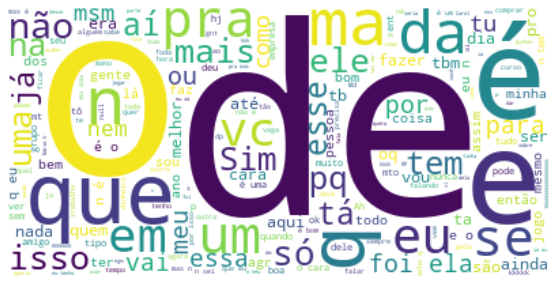

In [90]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))
stopwords = set(STOPWORDS)
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Carolis


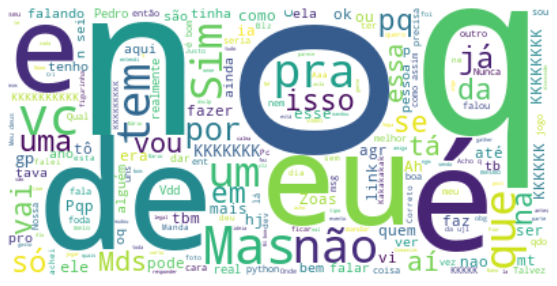

Author name Lucas UjL


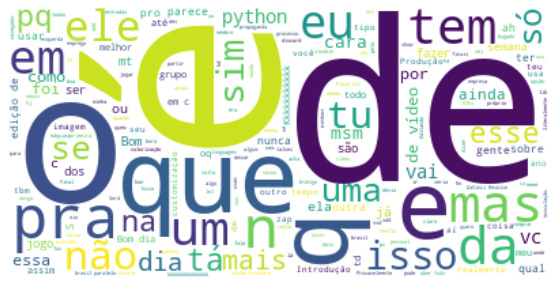

Author name Mário V.


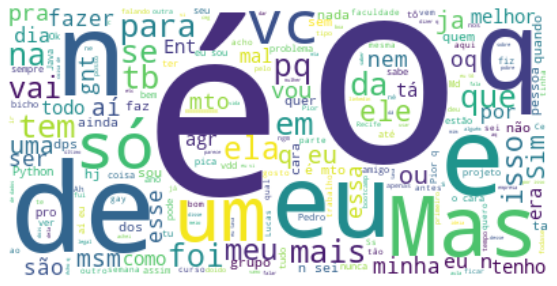

In [91]:
l = ["Carolis", "Lucas UjL", "Mário V."]
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  #Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  #Display the generated image   
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

**Observações importantes:**

- Eu e Lucas somos bem assertivos, então a palavra 'é' fica bem presente. O engraçado é que nos portamos com afirmações absolutas quando argumentamos
- A linguagem mais citada pelo grupo acima (Carolis, Lucas, Mário - Eu) foi Python. Nós três programamos/já estudamos Python

**Palavras notáveis:**
- Carolis falou muito sobre 'devs', e também possui muitos palavrões encurtados no vocabulário
- Lucas fala sobre vídeos, introdução, jogo. Talvez um indício de que ele costuma consumir conteúdo?
- Eu falo sobre projeto e faculdade. Provavelmente o que mais fala desse último tema no grupo. 
- Eu e Carol costumamos citar muito o Pedro.